# Loss Development

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from IPython.display import clear_output
import ipywidgets as widgets
import os
import math
from collections import OrderedDict

In [2]:
plt.rcParams["figure.figsize"] = (16,8)

In [3]:
def movingAverage(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

In [4]:
dirs = [d for d in sorted(os.listdir('.')) if os.path.isdir(d)]
wFolder = widgets.Dropdown(
    options=dirs,
    description='Experiment:',
)
display(wFolder)

Dropdown(description='Experiment:', options=('.ipynb_checkpoints', 'examples', 'test'), value='.ipynb_checkpoi…

In [5]:
experimentFolder = wFolder.value
print(experimentFolder)

test


In [6]:
nodesAmount = 0
dirs = [d for d in os.listdir(experimentFolder) if os.path.isdir(os.path.join(experimentFolder,d))]
for d in dirs:
    if 'worker' in d:
        nodesAmount += 1
print("Learners amount is ", str(nodesAmount))

Learners amount is  3


## Mean Loss Development Aligned by Amount of Examples Seen

In [7]:
displayStep = 100
# should be larger or equal to displayStep or it will just record same image several times
recordStep = 100
recordUnique = False
useMovingAverage = True
movingAverageWindow = 100

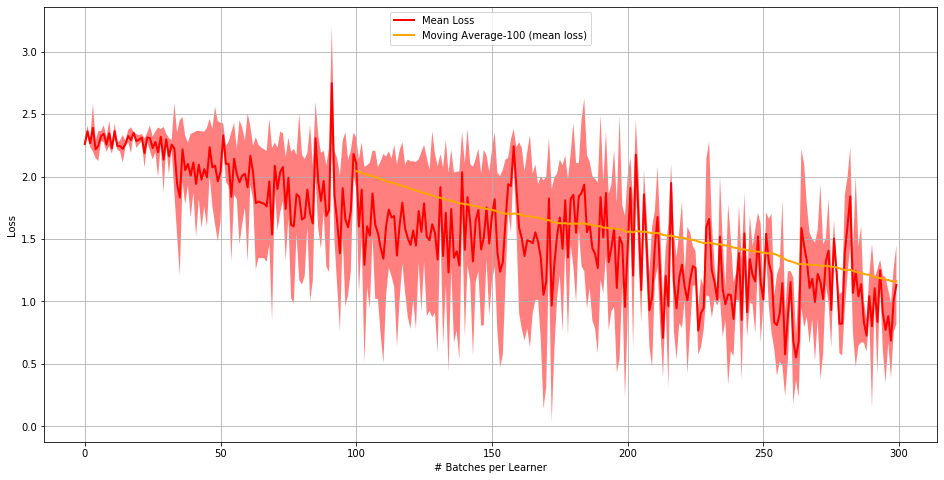

In [ ]:
files = []
losses = []
for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "losses.txt"), "r"))
    losses.append([])
    
t = [0]
commonStep = 0
count = 0

while 1:
    for i in range(nodesAmount):
        file = files[i]
        where = file.tell()
        line = file.readline()
        if line != '' and line[0] != 'T':
            if not line:
                time.sleep(1)
                file.seek(where)
            else:
                count += 1
                losses[i].append(float(line[:-1].split('\t\t')[1]))            
        currentStep = min([len(l) for l in losses])
        if currentStep > commonStep:
            commonStep = currentStep
            if commonStep % displayStep == 0:
                clear_output(wait=True)
                cutLosses = [l[:commonStep] for l in losses]
                mu = np.array(cutLosses).mean(axis=0)
                sigma = np.array(cutLosses).std(axis=0)
                fig = plt.figure()
                plt.plot(t, mu, lw=2, label='Mean Loss', color='red')
                plt.ylabel("Loss")
                plt.xlabel("# Batches per Learner")
                plt.fill_between(t, mu+sigma, mu-sigma, facecolor='red', alpha=0.5)
                if useMovingAverage and len(mu) > movingAverageWindow:
                    muMA = movingAverage(mu, movingAverageWindow)
                    plt.plot(t[movingAverageWindow:], muMA[movingAverageWindow:], lw=2, label='Moving Average-' + str(movingAverageWindow) + ' (mean loss)', 
                             color='orange')
                plt.legend(loc='upper center')
                plt.grid()
                plt.show()
            t.append(t[-1] + 1)        
            if commonStep % recordStep == 0:
                if recordUnique:
                    fig.savefig(os.path.join(experimentFolder, 'loss' + str(commonStep) + '.png'), dpi=100)
                else:
                    fig.savefig(os.path.join(experimentFolder, 'loss.png'), dpi=100)

In [120]:
for file in files:
    file.close()

## Loss Development per Learner

In [ ]:
displayStep = 1000
recordStep = 1000
recordUnique = False

In [ ]:
files = []
losses = []
for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "losses.txt"), "r"))
    losses.append([])
t = [0]
commonStep = 0

figs = []
while 1:
    for i in range(nodesAmount):
        file = files[i]
        where = file.tell()
        line = file.readline()
        if not line:
            time.sleep(1)
            file.seek(where)
        elif line and line[0]!='T':
            losses[i].append(float(line[:-1].split('\t\t')[1]))
    currentStep = min([len(l) for l in losses])
    if currentStep > commonStep:
        commonStep = currentStep
        if commonStep % displayStep == 0:
            clear_output(wait=True)
            cutLosses = [l[:commonStep] for l in losses]
            figs = []
            for i in range(nodesAmount):
                figs.append(plt.figure())
                plt.plot(t, cutLosses[i], lw=2, label='Loss Learner ' + str(i), color='red')
                plt.legend(loc='upper center')
                plt.ylabel("Loss")
                plt.xlabel("# Batches")
                plt.grid()
                # was used for video - not to change size of the plot and not to display ticks
                #plt.xlim(0,260)
                #plt.ylim(0,0.15)
                #plt.tick_params(colors=(0,0,0,0))
                plt.show()
        t.append(t[-1] + 1)
        if commonStep % recordStep == 0:
            j = 0
            for fig in figs:
                if recordUnique:
                    fig.savefig(os.path.join(experimentFolder, 
                                             'loss_learner' + str(j) + '_' + str(commonStep) + '.png'), dpi=100)
                else:
                    fig.savefig(os.path.join(experimentFolder, 'loss_learner' + str(j) + '.png'), dpi=100)
                j += 1

In [ ]:
for file in files:
    file.close()

## Mean Loss Development Aligned by Time

Here we have mean and deviation throught the whole system in some frequency step of time - not throughout local learners, but all the losses that occured during this time, i.e., it might be the case that one of the learners contributed more in current n seconds and the other less.

In [ ]:
# setup of the plots saving
displayStep = 1
recordStep = 1
recordUnique = False
uniqueImageCounter = 0
# draw a point for every second of experiment time
frequencyStep = 2
displaySync = True

In [ ]:
# get zero timestamp, i.e., beginning of the experiment
expSummary = open(os.path.join(experimentFolder,"summary.txt")).read()
for l in expSummary.split("\n"):
    if "Start" in l:
        startTimestamp = float(l.split("\t")[-1][:-1])
        break

In [ ]:
files = []
for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "losses.txt"), "r"))

if displaySync:
    syncFile = open(os.path.join(experimentFolder, "coordinator", "communication", "send_model.txt"), "r")

plot = {}
syncPoints = []
change = False
while True:
    for f in files:
        where = f.tell()
        line = f.readline()
        if line and line[0]!='T':
            change = True
            parsedLine = line[:-1].split("\t\t")
            lineTimestamp = float(parsedLine[0])
            # identify to which point in time this line will go
            xPoint = math.ceil((lineTimestamp - startTimestamp) / frequencyStep)
            loss = float(parsedLine[1])
            if plot.get(xPoint) is None:
                plot[xPoint] = [loss]
            else:
                plot[xPoint].append(loss)
    if displaySync:
        where = syncFile.tell()
        line = syncFile.readline()
        if line and line[0]!='T':
            change = True
            parsedLine = line[:-1].split("\t\t")
            lineTimestamp = float(parsedLine[0])
            # if model was sent only to one learner it is not a synchronization
            if parsedLine[2].count(".") > 1:
                syncPoints.append(math.ceil((lineTimestamp - startTimestamp) / frequencyStep))
          
    # do not need to call plotting if no new lines were read
    if not change:
        time.sleep(1)
        continue
    
    change = False
    if len(plot) % displayStep == 0:
        clear_output(wait=True)
        fig = plt.figure()
        orderedPlot = OrderedDict(sorted(plot.items(), key=lambda t: t[0]))
        mu = np.array([np.array(v).mean() for v in list(orderedPlot.values())])
        sigma = np.array([np.array(v).std() for v in list(orderedPlot.values())])
        plt.plot(list(orderedPlot.keys()), mu, lw=2, label='Mean Loss', color='red')
        if displaySync:
            displayedSyncs = [p for p in syncPoints if p < max(list(orderedPlot.keys()))]
            syncValues = []
            for s in displayedSyncs:
                if orderedPlot.get(s) is None:
                    val = orderedPlot.get(s, orderedPlot[min(orderedPlot.keys(), key=lambda k: abs(k-s))])
                    syncValues.append(np.array(val).mean())
                    #syncValues.append(np.array(next(iter(orderedPlot.items()))[1]).mean())
                else:
                    syncValues.append(np.array(orderedPlot[s]).mean())
            plt.scatter(displayedSyncs, syncValues, color='blue', alpha=0.6, lw=5, s=2500, marker='|')
        plt.fill_between(list(orderedPlot.keys()), mu+sigma, mu-sigma, facecolor='red', alpha=0.5)
        plt.legend(loc='upper center')
        plt.xlabel("Time (every " + str(frequencyStep) + "s)")
        plt.ylabel("Mean Loss")
        plt.ylim(ymax=0.205)
        plt.grid()
        plt.show()
    if len(plot) % recordStep == 0:
        if recordUnique:
            fig.savefig(os.path.join(experimentFolder, 
                                     'loss_time' + str(uniqueImageCounter) + '.png'), dpi=100)
            uniqueImageCounter += 1
        else:
            fig.savefig(os.path.join(experimentFolder, 'loss_time.png'), dpi=100)        

In [ ]:
for file in files:
    file.close()

if displaySync:
    syncFile.close()